In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision
import torch
import numpy as np

/home/hellottie/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/home/hellottie/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
color_map = {
    (1,88,255): 0,  # sky - blue
    (156,76,30): 1,      # rough trail - brown
    (178,176,153): 2,   # smooth trail - grey
    (128,255,0): 3,      # traversable grass - light green
    (40,80,0): 4,    # high vegetation - dark green
    (0,160,0): 5,      # non-traversable low vegetation - medium green
    (255,0,128): 6,     # puddle - pink
    (255,0,0): 7,  # obstacle - red
    (255,255,255) : 8, # undefined - white
}

def convert_rgb_to_onehotencoding(label_img):
    label_np = np.array(label_img)  # (H, W, 3) - RGB
    h, w, _ = label_np.shape
    onehot = np.zeros((len(color_map), h, w), dtype=np.uint8) #uint8 as precised in the consegna

    for rgb, class_idx in color_map.items():
        mask = np.all(label_np == rgb, axis=-1)
        onehot[class_idx][mask] = 1

    return torch.from_numpy(onehot).float()

In [3]:
class ImageSegmentationTrainingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.folders = sorted(os.listdir(root_dir))
        self.transform = transform

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        folder_path = os.path.join(self.root_dir, self.folders[idx])
        rgb_path = os.path.join(folder_path, 'rgb.jpg')
        label_path = os.path.join(folder_path, 'labels.png')

        rgb_image = Image.open(rgb_path).convert('RGB')
        label_image = Image.open(label_path).convert('RGB')

        label_onehotencoding = convert_rgb_to_onehotencoding(label_image)

        if self.transform:
            rgb_image = self.transform(rgb_image)
            label_image = self.transform(label_image)
        

        return rgb_image,label_image,label_onehotencoding

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = ImageSegmentationTrainingDataset(root_dir='train', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

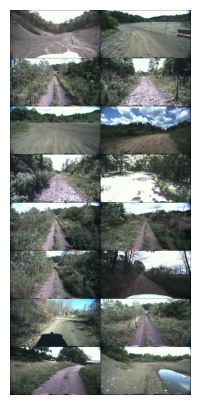

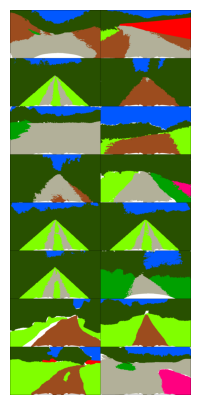

torch.Size([16, 9, 544, 1024])


In [7]:
def show_images_batch(images):
    grid = torchvision.utils.make_grid(images, nrow=2)
    plt.figure(figsize=(10, 5))
    plt.imshow(grid.permute(1, 2, 0))  # convert (chanel, height, width) -> (height, width, channel)
    plt.axis('off')
    plt.show()

# Iterate and display one batch
for images,labels,onehotencoding in dataloader: # for batch in batches
    show_images_batch(images)
    show_images_batch(labels)
    print(onehotencoding.shape)
    break

In [6]:
# Define color -> class index map
# Files used to have every colors : 0392 0246 0305

def get_unique_colors(label_path):
    label_img = Image.open(label_path).convert("RGB")
    label_np = np.array(label_img)
    h, w, _ = label_np.shape

    # Reshape to (N, 3) and find unique colors
    unique_colors = np.unique(label_np.reshape(-1, 3), axis=0)
    return [tuple(color) for color in unique_colors]

#label_colors = get_unique_colors("train/0305/labels.png")
#print("Unique colors in label:", label_colors)
